# Лабораторная работа №5: "Ансамбли моделей машинного обучения".

## Загрузка датасета

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from heamy.estimator import Regressor
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset
from sklearn.neural_network import MLPRegressor
from gmdhpy import gmdh
from warnings import simplefilter

simplefilter('ignore')

In [6]:
data = pd.read_csv('cars_price_2_processed.csv')
data.head()

,Unnamed: 0,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price,Location_Ahmedabad,Location_Bangalore,...,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,0,2010,72000,26.60,998,58.16,5.0,1.75,0,0,...,1,0,0,0,0,1,1,0,0,0
1,1,2015,41000,19.67,1582,126.20,5.0,12.50,0,0,...,0,1,0,0,0,1,1,0,0,0
2,2,2011,46000,18.20,1199,88.70,5.0,4.50,0,0,...,0,0,0,1,0,1,1,0,0,0
3,3,2012,87000,20.77,1248,88.76,7.0,6.00,0,0,...,0,1,0,0,0,1,1,0,0,0
4,4,2013,40670,15.20,1968,140.80,5.0,17.74,0,0,...,0,1,0,0,1,0,0,0,1,0


## Корреляционный анализ

In [7]:
print('Признаки, имеющие максимальную по модулю корреляцию с ценой автомобиля')
best_params = data.corr()['Price'].map(abs).sort_values(ascending=False)[1:]
best_params = best_params[best_params.values > 0.3]
best_params

Признаки, имеющие максимальную по модулю корреляцию с ценой автомобиля


Power                     0.772843
Engine                    0.658047
Transmission_Automatic    0.585623
Transmission_Manual       0.585623
Mileage                   0.341652
Fuel_Type_Diesel          0.321035
Fuel_Type_Petrol          0.309363
Name: Price, dtype: float64

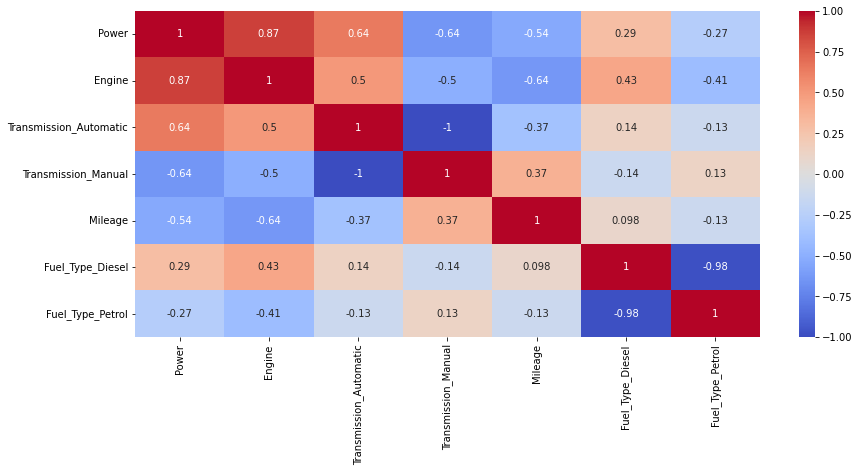

In [8]:
plt.figure(figsize=(14, 6))
sns.heatmap(data[best_params.index].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

In [9]:
best_params = best_params.drop(['Engine', 'Transmission_Manual', 'Fuel_Type_Petrol'])

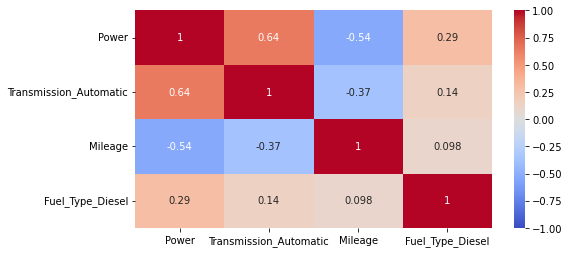

In [10]:
plt.figure(figsize=(8, 4))
sns.heatmap(data[best_params.index].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

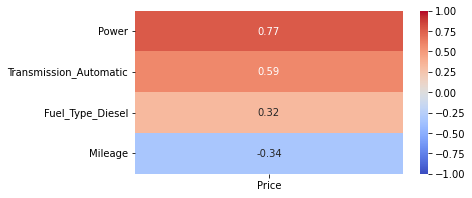

In [11]:
plt.figure(figsize=(6, 3))
sns.heatmap(pd.DataFrame(data[np.append(best_params.index.values, 'Price')].corr()['Price'].sort_values(ascending=False)[1:]), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

## Разделение выборки на обучающую и тестовую

In [12]:
y = data['Price']
X = data[best_params.index]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

## Масштабирование данных

In [13]:
scaler = StandardScaler().fit(x_train)
x_train_scaled = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_train.columns)

## Метрики

In [14]:
def print_metrics(y_test, y_pred):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

## Модель №1: Случайный лес

In [15]:
print_metrics(y_test, RandomForestRegressor(random_state=17).fit(x_train, y_train).predict(x_test))

R^2: 0.8169695703110462
MSE: 21.368523550280464
MAE: 2.2272108897882124


### Подбор гиперпараметров

In [16]:
rf = RandomForestRegressor(random_state=17)
params = {'n_estimators': [100, 1000], 'criterion': ['squared_error', 'absolute_error', 'poisson'], 
          'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 3, 5]}
grid_cv = GridSearchCV(estimator=rf, cv=5, param_grid=params, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)

{'criterion': 'absolute_error', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}


In [17]:
best_rf = grid_cv.best_estimator_
best_rf.fit(x_train, y_train)
y_pred_rf = best_rf.predict(x_test)
print_metrics(y_test, y_pred_rf)

R^2: 0.8208117147424516
MSE: 20.919959047068673
MAE: 2.1854572077185015


## Модель №2: Градиентный бустинг

In [18]:
print_metrics(y_test, GradientBoostingRegressor(random_state=17).fit(x_train, y_train).predict(x_test))

R^2: 0.7712549309952805
MSE: 26.705637976944956
MAE: 2.8692068306824234


### Подбор гиперпараметров

In [19]:
gb = GradientBoostingRegressor(random_state=17)
params = {'loss': ['squared_error', 'absolute_error', 'huber'], 'n_estimators': [10, 50, 100, 200], 
          'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'], 'min_samples_leaf': [1, 3, 5]}
grid_cv = GridSearchCV(estimator=gb, cv=5, param_grid=params, n_jobs=-1, scoring='r2')
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)

{'criterion': 'friedman_mse', 'loss': 'huber', 'min_samples_leaf': 3, 'n_estimators': 200}


In [20]:
best_gb = grid_cv.best_estimator_
best_gb.fit(x_train, y_train)
y_pred_gb = best_gb.predict(x_test)
print_metrics(y_test, y_pred_gb)

R^2: 0.7750617066966918
MSE: 26.26120271902374
MAE: 2.66518306958836


## Модель №3: Стекинг

In [21]:
dataset = Dataset(x_train, y_train, x_test)

In [22]:
model_lr = Regressor(dataset=dataset, estimator=LinearRegression, name='lr')
model_rf = Regressor(dataset=dataset, estimator=RandomForestRegressor, 
                     parameters={'criterion': 'absolute_error', 'n_estimators': 1000, 'random_state': 17}, name='rf')
model_gb = Regressor(dataset=dataset, estimator=GradientBoostingRegressor, 
                     parameters={'loss': 'huber', 'random_state': 17}, name='rf')

In [23]:
pipeline = ModelsPipeline(model_lr, model_rf)
stack_ds = pipeline.stack(k=10, seed=1)
stacker = Regressor(dataset=stack_ds, estimator=GradientBoostingRegressor)
results = stacker.validate(k=10, scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [2.118518079925378, 2.366942214889117, 2.654642030745365, 2.4726790895523836, 2.343767119086641, 2.341834955257515, 2.82948363821963, 2.09283849153532, 2.8587044048057866, 2.3338125113348562]
Mean accuracy: 2.441322253535199
Standard Deviation: 0.2516971648119532
Variance: 0.06335146277437553


In [24]:
y_pred_stack = stacker.predict()
print_metrics(y_test, y_pred_stack)

R^2: 0.7840610516996481
MSE: 25.21054291365927
MAE: 2.3494797099849425


## Модель №4: Многослойный персептрон

In [25]:
print_metrics(y_test, MLPRegressor(random_state=17).fit(x_train, y_train).predict(x_test))

R^2: 0.6461253526988189
MSE: 41.31432542421033
MAE: 3.6332677362127788


### Подбор гиперпараметров

In [26]:
mlp = MLPRegressor(random_state=17)
params = {'solver': ['lbfgs', 'sgd', 'adam'], 'hidden_layer_sizes': [(100,), (50, 30,), (100, 40,)], 
          'alpha': [1e-4, 3e-4, 5e-4], 'max_iter': [500, 1000]}
grid_cv = GridSearchCV(estimator=mlp, cv=5, param_grid=params, n_jobs=-1, scoring='r2')
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)

{'alpha': 0.0001, 'hidden_layer_sizes': (100, 40), 'max_iter': 1000, 'solver': 'lbfgs'}


In [27]:
best_mlp = grid_cv.best_estimator_
best_mlp.fit(x_train, y_train)
y_pred_mlp = best_mlp.predict(x_test)
print_metrics(y_test, y_pred_mlp)

R^2: 0.6795190063389385
MSE: 37.415667286044616
MAE: 3.4568890196314794


## Модель №5: Метод группового учёта аргументов

In [28]:
gm = gmdh.Regressor(n_jobs=-1)
gm.fit(np.array(x_train_scaled), np.array(y_train))
y_pred_gm = gm.predict(np.array(x_test_scaled))
print()
print_metrics(y_test, y_pred_gm)

train layer0 in 0.02 sec
train layer1 in 0.05 sec
train layer2 in 0.05 sec
train layer3 in 0.05 sec

R^2: 0.6866573748606544
MSE: 36.58227364693177
MAE: 3.3962429053289607


## Сравнение моделей

In [29]:
print("Случайный лес")
print_metrics(y_test, y_pred_rf)

print("\nГрадиентный бустинг")
print_metrics(y_test, y_pred_gb)

print("\nСтекинг")
print_metrics(y_test, y_pred_stack)

print("\nМногослойный персептрон")
print_metrics(y_test, y_pred_mlp)

print("\nМетод группового учёта аргументов")
print_metrics(y_test, y_pred_gm)

Случайный лес
R^2: 0.8208117147424516
MSE: 20.919959047068673
MAE: 2.1854572077185015

Градиентный бустинг
R^2: 0.7750617066966918
MSE: 26.26120271902374
MAE: 2.66518306958836

Стекинг
R^2: 0.7840610516996481
MSE: 25.21054291365927
MAE: 2.3494797099849425

Многослойный персептрон
R^2: 0.6795190063389385
MSE: 37.415667286044616
MAE: 3.4568890196314794

Метод группового учёта аргументов
R^2: 0.6866573748606544
MSE: 36.58227364693177
MAE: 3.3962429053289607


**Вывод:** Все модели показали хороший результат. Лучшей по всем используемым метрикам оказалась модель случайного леса.